In [196]:
# Import data
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Data is stored in external directory
path = "../../grad_cafe_admissions.csv"
fields = []
rows = []
 
# reading csv file
with open(path, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
     
    # extracting field names through first row
    fields = next(csvreader)
 
    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)

In [197]:
df = pd.DataFrame (rows, columns = fields)

In [198]:
nan_count=list()
for field in fields:
    nan_count.append(df[df[field]=='NA'][field].count())

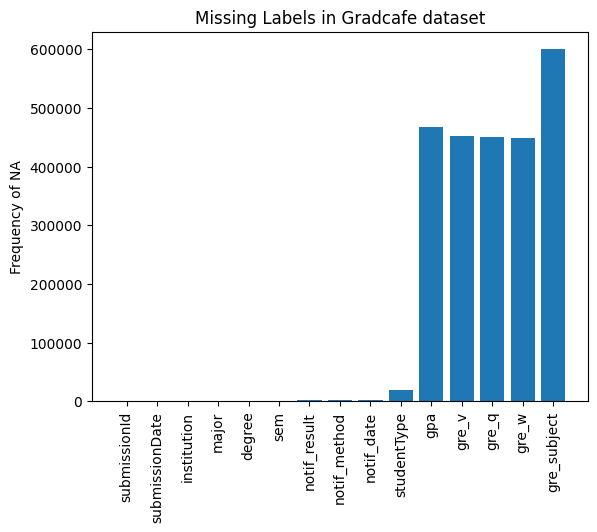

In [199]:
plt.bar(list(range(len(nan_count))), nan_count)
plt.xticks(list(range(len(nan_count))), fields, rotation=90)
plt.ylabel('Frequency of NA')
plt.title('Missing Labels in Gradcafe dataset')
plt.show()

In [200]:
# Find median for every field
import numpy as np
field_mean = dict()
field_median = dict()
for field in fields[-5:]:
    x = df[df[field].str.isnumeric()][[field]]
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    field_mean[field] = x.to_numpy().astype(float).mean()
    field_median[field] = x.median().iat[0]
    print("For {0}:".format(field))
    print("Median is {0}".format(field_median[field]))
    print("Mean is {0} \n".format(field_mean[field]))

For gpa:
Median is 4.0
Mean is 3.965470500107013 

For gre_v:
Median is 160.0
Mean is 158.28645551895042 

For gre_q:
Median is 162.0
Mean is 160.3524564110566 

For gre_w:
Median is 4.0
Mean is 3.9401579852508233 

For gre_subject:
Median is 790.0
Mean is 762.415358904333 



In [201]:
# Duplicate and impute the series with mean statistic
# Only pick in gre_subjects
df_new = df
df_imputed = df_new[(df_new["gpa"].str.isnumeric()==True) & \
           (df_new["gre_v"].str.isnumeric()==True) & \
           (df_new["gre_q"].str.isnumeric()==True) & \
           (df_new["gre_w"].str.isnumeric()==True) & \
           (df_new["gre_subject"].str.isnumeric()==True) ]
for field in fields[-5:]:
    df_imputed.loc[(df_imputed[field].str.isnumeric()==False), field]=field_mean[field]
df_imputed

/var/folders/bd/y38b3rb96b90p6bnpfms_2ww0000gn/T/ipykernel_7009/3966859800.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed.loc[(df_imputed[field].str.isnumeric()==False), field]=field_mean[field]


,submissionId,submissionDate,institution,major,degree,sem,notif_result,notif_method,notif_date,studentType,gpa,gre_v,gre_q,gre_w,gre_subject
54843,64519,2010-01-12,Stanford University,Psychology,PhD,F10,Interview,E-mail,2010-01-12,A,4,164,166,5,780
55047,64749,2010-01-15,"University Of Michigan, Ann Arbor",Social Psychology,PhD,F10,Rejected,E-mail,2010-01-15,A,4,164,166,5,780
55336,65057,2010-01-21,Florida State University,Counseling Psychology,PhD,F10,Interview,E-mail,2009-11-23,U,4,159,155,4,810
55337,65058,2010-01-21,University Of Iowa,Counseling Psychology,PhD,F10,Interview,E-mail,2010-01-07,U,4,159,155,4,810
55447,65187,2010-01-22,Michigan State University,Social Psychology,PhD,F10,Interview,E-mail,2010-01-19,A,4,164,166,5,780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623440,628856,2019-02-17,University Of Denver,Clinical Psychology,Other,F18,Interview,E-mail,2018-12-21,A,4,165,154,4,720
623441,628855,2019-02-17,PGSP-Stanford,Clinical Psychology,Other,F19,Interview,E-mail,2019-01-09,A,4,165,154,4,720
623446,628850,2019-02-17,Loyola Maryland,Clinical Psychology,Other,F19,Rejected,E-mail,2019-01-15,A,4,165,154,4,720
623453,628843,2019-02-17,Palo Alto University,Clinical Psychology,PhD,F19,Accepted,E-mail,2019-01-18,A,4,165,154,4,720


In [236]:
# Check the dataframe
from pandas.api.types import CategoricalDtype
cats = ["Accepted", "Rejected"]
cat_type = CategoricalDtype(categories=cats, ordered=False)

X = df_imputed[fields[-5:]].to_numpy()
Y_cat = df_imputed[fields[-9]].astype(cat_type)
Y = Y_cat.cat.codes.to_numpy() + 1
Y_labels = Y_cat.cat.categories
Z = list()
Z_label = list()
for field in ["institution", "major", "degree", "sem"]:
    Z_cat = df_imputed[field].astype(CategoricalDtype())
    Z.append(Z_cat.cat.codes.to_numpy())
    Z_label.append(Z_cat.cat.categories)
Z = np.array(Z).T
X.shape, Y.shape, Y_labels, Z.shape

((1342, 5),
 (1342,),
 Index(['Accepted', 'Rejected'], dtype='object'),
 (1342, 4))

In [229]:
# K-fold cross Validation
from sklearn.model_selection import KFold
k = 10
# prepare cross validation
kf = KFold(n_splits=k)
# enumerate splits
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = GaussianNB()
    clf.fit(np.hstack((X[train_index], Z[train_index])), Y[train_index])
    print(clf.score(np.hstack((X[test_index], Z[test_index])), Y[test_index]))

0.4222222222222222
0.4222222222222222
0.5074626865671642
0.5895522388059702
0.4552238805970149
0.5298507462686567
0.44776119402985076
0.5373134328358209
0.4701492537313433
0.5895522388059702


In [230]:
# K-fold cross Validation
from sklearn.model_selection import KFold
k = 10
# prepare cross validation
kf = KFold(n_splits=k)
# enumerate splits
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = GaussianNB()
    clf.fit(np.hstack((X[train_index][:,:-3], Z[train_index])), Y[train_index])
    print(clf.score(np.hstack((X[test_index][:,:-3], Z[test_index])), Y[test_index]))

0.43703703703703706
0.45925925925925926
0.5746268656716418
0.5895522388059702
0.4701492537313433
0.5522388059701493
0.4626865671641791
0.48507462686567165
0.4626865671641791
0.5597014925373134


In [267]:
# Per-degree accuracy
for i, degree in enumerate(Z_label[2]):
    idx = np.where(Z[:,2] == i)[0]
    if len(idx)>10:
        accuracy = list()
        for i, (train_index, test_index) in enumerate(kf.split(idx)):
            clf = GaussianNB()
            clf.fit(np.hstack((X[idx[train_index]][:,:-3], Z[idx[train_index]][:,1:])), Y[idx[train_index]])
            accuracy.append(clf.score(np.hstack((X[idx[test_index]][:,:-3], Z[idx[test_index]][:,1:])), Y[idx[test_index]]))
        print("{0}: Number of samples: {1} Mean Accuracy: {2:.3f}% Std dev: {3:.3f}% Max Accuracy {4:.3f}%".format(degree, len(idx), np.mean(accuracy)*100, np.std(accuracy)*100, np.max(accuracy)*100))

Masters: Number of samples: 66 Mean Accuracy: 50.000% Std dev: 23.833% Max Accuracy 85.714%
Other: Number of samples: 13 Mean Accuracy: 60.000% Std dev: 43.589% Max Accuracy 100.000%
PhD: Number of samples: 1261 Mean Accuracy: 50.204% Std dev: 5.720% Max Accuracy 60.317%


Text(0.5, 1.0, 'Histogram for number of samples for University')

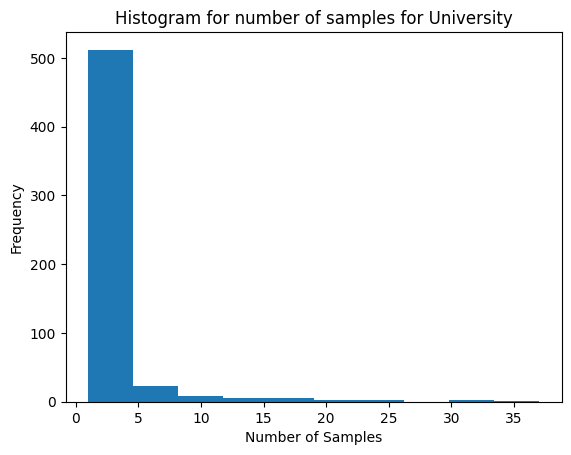

In [272]:
# Per-university samples
samples = list()
for i, uni in enumerate(Z_label[0]):
    idx = np.where(Z[:,0] == i)[0]
    samples.append(len(idx))
plt.hist(samples)
plt.xlabel('Number of Samples')
plt.ylabel('Frequency')
plt.title('Histogram for number of samples for University')

Text(0.5, 1.0, 'Histogram for number of samples for degree programs')

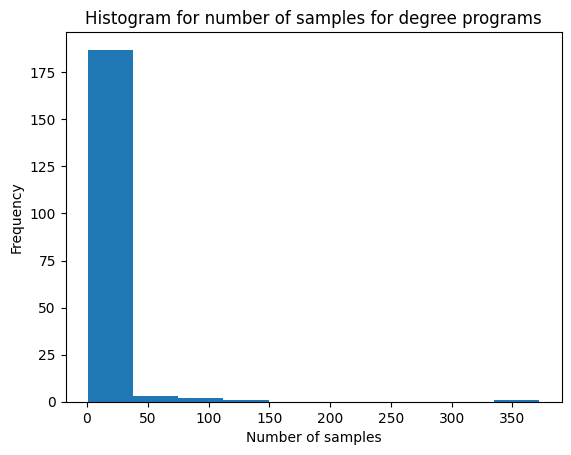

In [273]:
# Per-program samples
samples = list()
for i, prog in enumerate(Z_label[1]):
    idx = np.where(Z[:,1] == i)[0]
    samples.append(len(idx))
plt.hist(samples)
plt.xlabel('Number of samples')
plt.ylabel('Frequency')
plt.title('Histogram for number of samples for degree programs')

In [276]:
# Per-program accuracy
for i, program in enumerate(Z_label[1]):
    idx = np.where(Z[:,1] == i)[0]
    if len(idx)>10:
        accuracy = list()
        for i, (train_index, test_index) in enumerate(kf.split(idx)):
            clf = GaussianNB()
            clf.fit(np.hstack((X[idx[train_index]][:,:-3], Z[idx[train_index]][:,1:])), Y[idx[train_index]])
            accuracy.append(clf.score(np.hstack((X[idx[test_index]][:,:-3], \
                                                 Z[idx[test_index]][:,1:])), Y[idx[test_index]]))
        print("{0}: \n Number of samples: {1} Mean Accuracy: {2:.3f}% Std dev: {3:.3f}% Max Accuracy {4:.3f}% \n".\
              format(program, len(idx), np.mean(accuracy)*100, np.std(accuracy)*100, np.max(accuracy)*100))

(English): 
 Number of samples: 14 Mean Accuracy: 80.000% Std dev: 33.166% Max Accuracy 100.000% 

(English) - Literature: 
 Number of samples: 19 Mean Accuracy: 25.000% Std dev: 25.000% Max Accuracy 50.000% 

(Pure) Mathematics: 
 Number of samples: 31 Mean Accuracy: 35.833% Std dev: 27.901% Max Accuracy 66.667% 

Applied Physics: 
 Number of samples: 20 Mean Accuracy: 85.000% Std dev: 22.913% Max Accuracy 100.000% 

Astronomy: 
 Number of samples: 41 Mean Accuracy: 47.500% Std dev: 28.395% Max Accuracy 75.000% 

Chemistry: 
 Number of samples: 93 Mean Accuracy: 13.000% Std dev: 10.750% Max Accuracy 33.333% 

Clinical Psychology: 
 Number of samples: 66 Mean Accuracy: 35.238% Std dev: 26.785% Max Accuracy 83.333% 

Computer Science: 
 Number of samples: 21 Mean Accuracy: 41.667% Std dev: 38.188% Max Accuracy 100.000% 

English: 
 Number of samples: 136 Mean Accuracy: 45.824% Std dev: 18.067% Max Accuracy 76.923% 

Mathematics: 
 Number of samples: 101 Mean Accuracy: 17.818% Std dev: 1